PyTorch version: 2.0.0+cu117
Using device: cpu
Generated 200 synthetic texts
Sample text: Once upon a time, there was a happy queen who explored powerfully. One day, the queen decided to exp...
Epoch 1/3, Batch 10/50, Loss: 4.9713
Epoch 1/3, Batch 20/50, Loss: 4.3359
Epoch 1/3, Batch 30/50, Loss: 3.9930
Epoch 1/3, Batch 40/50, Loss: 3.6046
Epoch 1/3, Batch 50/50, Loss: 3.3792
Epoch 1/3, Average Loss: 4.2100
Epoch 2/3, Batch 10/50, Loss: 3.0219
Epoch 2/3, Batch 20/50, Loss: 3.1327
Epoch 2/3, Batch 30/50, Loss: 2.9107
Epoch 2/3, Batch 40/50, Loss: 2.6205
Epoch 2/3, Batch 50/50, Loss: 2.4788
Epoch 2/3, Average Loss: 2.8752
Epoch 3/3, Batch 10/50, Loss: 2.6366
Epoch 3/3, Batch 20/50, Loss: 2.4761
Epoch 3/3, Batch 30/50, Loss: 2.0136
Epoch 3/3, Batch 40/50, Loss: 2.2747
Epoch 3/3, Batch 50/50, Loss: 2.2046
Epoch 3/3, Average Loss: 2.2776


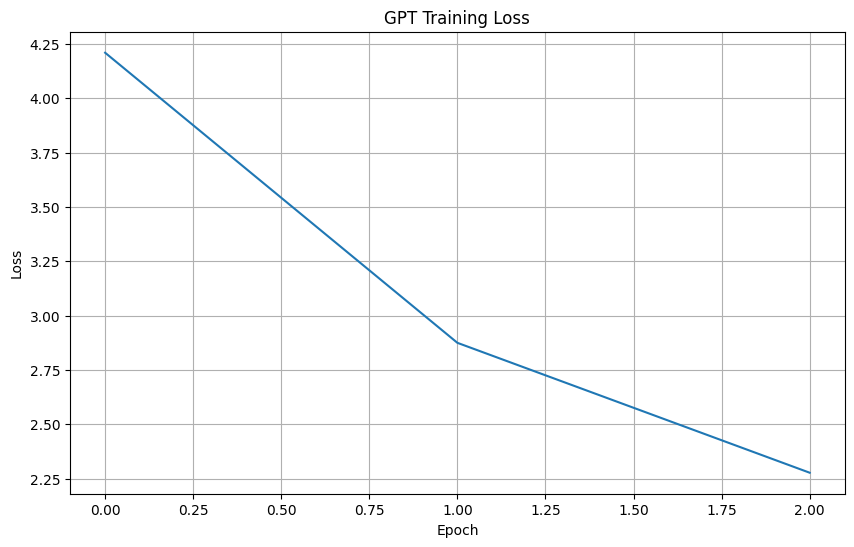

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import time
import copy
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
print(f"PyTorch version: {torch.__version__}")

# Set random seed for reproducibility
def set_seed(seed):
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


set_seed(42)

# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class PositionalEncoding(nn.Module):
    """
    Adds positional information to token embeddings.
    Uses fixed sinusoidal embeddings as in the original Transformer paper.
    """
    def __init__(self, d_model, max_seq_length=1024, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension [1, max_seq_length, d_model]
        pe = pe.unsqueeze(0)

        # Register buffer (persistent state)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism.
    Allows the model to jointly attend to information from different positions.
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.output = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, q, k, v, mask=None):
        """
        Args:
            q: Query tensor, shape [batch_size, seq_len_q, d_model]
            k: Key tensor, shape [batch_size, seq_len_k, d_model]
            v: Value tensor, shape [batch_size, seq_len_k, d_model]
            mask: Optional mask tensor, shape [batch_size, 1, seq_len_q, seq_len_k]
        """
        batch_size = q.size(0)

        # Linear projections and split heads
        q = self.query(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.key(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.value(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scale dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention weights to values
        context = torch.matmul(attn_weights, v)

        # Reshape and concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Final projection
        output = self.output(context)

        return output, attn_weights


class FeedForward(nn.Module):
    """
    Position-wise feed-forward network.
    Consists of two linear transformations with a GELU activation in between.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def gelu(self, x):
        """
        Implementation of the GELU activation function.
        """
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

    def forward(self, x):
        """
        Args:
            x: Input tensor, shape [batch_size, seq_len, d_model]
        """
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x



class GPTBlock(nn.Module):
    """
    Transformer block used in GPT.
    Consists of multi-head self-attention and feed-forward network.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(GPTBlock, self).__init__()

        # Layer normalization
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)

        # Feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Args:
            x: Input tensor, shape [batch_size, seq_len, d_model]
            mask: Optional mask for attention, shape [batch_size, 1, seq_len, seq_len]
        """
        # Pre-LN architecture (different from original GPT but more stable)
        ln_x = self.ln1(x)

        # Self-attention
        attention_output, _ = self.attention(ln_x, ln_x, ln_x, mask)
        attention_output = self.dropout(attention_output)

        # Residual connection after attention
        x = x + attention_output

        # Layer normalization before feed-forward
        ln_x = self.ln2(x)

        # Feed-forward network
        ff_output = self.feed_forward(ln_x)
        ff_output = self.dropout(ff_output)

        # Residual connection after feed-forward
        x = x + ff_output

        return x



class GPT(nn.Module):
    """
    GPT model implementation.
    A stack of Transformer blocks with token embeddings and positional encoding.
    """
    def __init__(self, vocab_size, d_model=768, n_layers=12, n_heads=12, d_ff=3072,
                 max_seq_length=1024, dropout=0.1, padding_idx=0):
        super(GPT, self).__init__()

        # Token embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=padding_idx)

        # Positional encoding
        self.position_encoding = PositionalEncoding(d_model, max_seq_length, dropout)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            GPTBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        # Final layer normalization
        self.ln_f = nn.LayerNorm(d_model)

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size, bias=False)

        # Initialize weights
        self.apply(self._init_weights)

        # Tie embedding and output weights
        self.token_embedding.weight = self.output_projection.weight

    def _init_weights(self, module):
        """
        Initialize the weights.
        """
        if isinstance(module, nn.Linear):
            # Small initialization for stability
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, input_ids, past_key_values=None, attention_mask=None):
        """
        Args:
            input_ids: Token IDs, shape [batch_size, seq_len]
            past_key_values: Cached key/value pairs for faster generation (not implemented in this version)
            attention_mask: Mask to prevent attention to padding tokens, shape [batch_size, seq_len]
        """
        batch_size, seq_length = input_ids.size()

        # Create causal attention mask
        causal_mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool()
        causal_mask = causal_mask.to(input_ids.device)

        # Convert to attention mask (1 = attend, 0 = don't attend)
        # Shape: [batch_size, 1, seq_length, seq_length]
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(1).expand(batch_size, 1, seq_length, seq_length)
        causal_mask = (1.0 - causal_mask.float()) * -1e9

        # Combine with padding mask if provided
        if attention_mask is not None:
            # Convert attention_mask: [batch_size, seq_length] -> [batch_size, 1, 1, seq_length]
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            attention_mask = (1.0 - attention_mask) * -1e9

            # Add the masks together
            causal_mask = causal_mask + attention_mask

        # Token embeddings
        token_embeddings = self.token_embedding(input_ids)

        # Add positional encodings
        x = self.position_encoding(token_embeddings)

        # Apply dropout
        x = self.dropout(x)

        # Process through transformer blocks
        for block in self.blocks:
            x = block(x, causal_mask)

        # Final layer normalization
        x = self.ln_f(x)

        # Output projection
        logits = self.output_projection(x)

        return logits




# --- Training functions ---
class GPTLanguageModelingDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=1024):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Tokenize all texts
        self.tokenized_texts = []
        for text in texts:
            self.tokenized_texts.append(torch.tensor(tokenizer.encode(text), dtype=torch.long))

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, idx):
        tokenized_text = self.tokenized_texts[idx]

        # Check if any token ID is out of range
        max_id = self.tokenizer.vocab_size - 1
        tokenized_text = torch.clamp(tokenized_text, 0, max_id)

        # Prepare input and target
        input_ids = tokenized_text[:-1]  # All tokens except the last one
        target_ids = tokenized_text[1:]  # All tokens except the first one

        return input_ids, target_ids


def train_gpt(model, train_dataloader, optimizer, scheduler, num_epochs, device):
    """
    Train the GPT model.

    Args:
        model: The GPT model
        train_dataloader: DataLoader for training data
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Number of training epochs
        device: Device to train on

    Returns:
        losses: List of training losses
    """
    model.train()
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, (input_ids, target_ids) in enumerate(train_dataloader):
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(input_ids)

            # Calculate loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_ids.view(-1))

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters
            optimizer.step()

            # Update learning rate
            scheduler.step()

            # Track loss
            total_loss += loss.item()

            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

        # Calculate average loss
        avg_loss = total_loss / len(train_dataloader)
        losses.append(avg_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

    return losses



# class SimpleTokenizer:
#     def __init__(self):
#         # Basic vocabulary: ASCII printable characters (32-126) + special tokens
#         self.vocab = {chr(i): i for i in range(32, 127)}

#         # Add special tokens
#         self.vocab['<pad>'] = 0
#         self.vocab['<unk>'] = 1
#         self.vocab['<eos>'] = 2

#         # Create inverse mapping
#         self.id_to_token = {v: k for k, v in self.vocab.items()}

#         # Set attributes for compatibility
#         self.pad_token_id = 0
#         self.unk_token_id = 1
#         self.eos_token_id = 2

#         # Vocabulary size
#         self.vocab_size = len(self.vocab)

#     def encode(self, text):
#         """Encode text to token IDs."""
#         ids = []
#         for c in text:
#             # Ensure token is in vocabulary, otherwise use <unk>
#             if c in self.vocab:
#                 ids.append(self.vocab[c])
#             else:
#                 ids.append(self.unk_token_id)
#         ids.append(self.eos_token_id)  # Add EOS token
#         return ids

#     def decode(self, ids):
#         """Decode token IDs to text."""
#         return ''.join(self.id_to_token.get(i, '<unk>') for i in ids)

class Tokenizer:
    
    def __init__(self):
        # Basic vocabulary with common words and punctuation
        self.special_tokens = {
            '<pad>': 0,
            '<unk>': 1,
            '<eos>': 2,
            '<bos>': 3
        }

        # Create initial vocabulary with special tokens
        self.vocab = {k: v for k, v in self.special_tokens.items()}

        # Add common words
        common_words = [
            "the", "a", "an", "and", "or", "but", "if", "of", "to", "in", "on", "at", "by", "for", "with",
            "about", "against", "between", "into", "through", "during", "before", "after", "above", "below",
            "from", "up", "down", "out", "off", "over", "under", "again", "further", "then", "once", "here",
            "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other",
            "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "can", "will",
            "just", "should", "now", "was", "were", "is", "are", "be", "been", "being", "have", "has", "had",
            "time", "like", "look", "people", "way", "day", "man", "woman", "child", "person", "year", "good",
            "new", "first", "last", "long", "great", "little", "own", "work", "well", "back", "think", "see",
            "come", "say", "know", "get", "go", "make", "take", "use", "find", "want", "give", "tell",
            "would", "could", "should", "may", "might", "must", "shall", "will", "can", "he", "she", "it", "I",
            "you", "they", "we", "who", "what", "which", "their", "our", "your", "my", "his", "her", "its",
            "once", "upon", "time", "happy", "sad", "brave", "timid", "clever", "foolish", "young", "old",
            "cat", "dog", "king", "queen", "hero", "villain", "wizard", "dragon", "ran", "jumped", "flew",
            "swam", "ate", "slept", "fought", "laughed"
        ]

        # Add punctuation and numbers
        punctuation = [".", ",", "!", "?", ":", ";", "'", "\"", "-", "(", ")", "[", "]", "{", "}", "/"]
        numbers = [str(i) for i in range(10)]

        # Add words to vocabulary
        for i, word in enumerate(common_words + punctuation + numbers, start=len(self.special_tokens)):
            self.vocab[word] = i

        # Create inverse mapping
        self.id_to_token = {v: k for k, v in self.vocab.items()}

        # Set attributes for compatibility
        self.pad_token_id = self.special_tokens['<pad>']
        self.unk_token_id = self.special_tokens['<unk>']
        self.eos_token_id = self.special_tokens['<eos>']
        self.bos_token_id = self.special_tokens['<bos>']

        # Vocabulary size
        self.vocab_size = len(self.vocab)

    def tokenize(self, text):
        """Split text into tokens."""
        # Simple word-level tokenization
        words = []
        current_word = ""
        for char in text:
            if char.isalnum():
                current_word += char
            else:
                if current_word:
                    words.append(current_word.lower())
                    current_word = ""
                if char.strip():  # If it's not whitespace
                    words.append(char)
        if current_word:
            words.append(current_word.lower())
        return words

    def encode(self, text):
        """Encode text to token IDs."""
        tokens = self.tokenize(text)
        ids = [self.bos_token_id]  # Start with BOS token

        for token in tokens:
            ids.append(self.vocab.get(token, self.unk_token_id))

        ids.append(self.eos_token_id)  # End with EOS token
        return ids

    def decode(self, ids):
        """Decode token IDs to text."""
        tokens = [self.id_to_token.get(i, '<unk>') for i in ids]
        # Filter out special tokens
        tokens = [t for t in tokens if t not in ['<pad>', '<unk>', '<eos>', '<bos>']]
        # Join tokens with spaces, but not for punctuation
        text = ""
        for token in tokens:
            if token in [".", ",", "!", "?", ":", ";", "'", "\"", "-", "(", ")", "[", "]", "{", "}", "/"]:
                text = text.rstrip() + token + " "
            else:
                text += token + " "
        return text.strip()

# --- Synthetic Text Generation ---
def generate_synthetic_texts(num_texts=200, min_length=200, max_length=1000):
    """
    Generate better synthetic texts for training.
    """
    texts = []

    story_templates = [
        "Once upon a time, there was a {adj} {noun} who {verb} {adv}. One day, the {noun} decided to {verb}. This led to a great adventure where the {noun} met a {adj} {noun2}. Together they {verb2} and learned that {lesson}.",
        "In a land far away, a {adj} {noun} lived peacefully. However, everything changed when the {adj2} {noun2} arrived. The {noun} had to {verb} to save the kingdom. With the help of a {adj3} {noun3}, they {verb2} and finally {verb3}.",
        "The {adj} {noun} woke up one morning and discovered that they could {verb}. This new ability made the {noun} very {adj2}. They decided to use this power to {verb2} and help the {adj3} {noun2}s in their village.",
        "There was once a {adj} {noun} who dreamed of {verb}ing. Everyone told the {noun} it was impossible, but the {noun} was determined. After months of practice, the {noun} finally {verb}ed and proved everyone wrong."
    ]

    adjectives = ["happy", "sad", "brave", "timid", "clever", "foolish", "young", "old", "mysterious", "magical", "powerful", "gentle", "fierce", "wise", "royal"]
    nouns = ["cat", "dog", "king", "queen", "hero", "villain", "wizard", "dragon", "knight", "princess", "prince", "warrior", "sorcerer", "farmer", "child"]
    verbs = ["ran", "jumped", "flew", "swam", "ate", "slept", "fought", "laughed", "danced", "sang", "studied", "explored", "discovered", "created", "built"]
    adverbs = ["quickly", "slowly", "bravely", "carefully", "happily", "sadly", "mysteriously", "magically", "powerfully", "gently"]
    lessons = ["friendship is magic", "never give up on your dreams", "courage comes from within", "kindness is the greatest strength", "true wisdom comes from experience"]

    for _ in range(num_texts):
        # Start with a basic story from a template
        base_story = random.choice(story_templates).format(
            adj=random.choice(adjectives),
            adj2=random.choice(adjectives),
            adj3=random.choice(adjectives),
            noun=random.choice(nouns),
            noun2=random.choice(nouns),
            noun3=random.choice(nouns),
            verb=random.choice(verbs),
            verb2=random.choice(verbs),
            verb3=random.choice(verbs),
            adv=random.choice(adverbs),
            lesson=random.choice(lessons)
        )

        # Add more content to reach the desired length
        current_length = len(base_story)
        text = base_story

        while current_length < min_length:
            # Add another paragraph
            paragraph = random.choice(story_templates).format(
                adj=random.choice(adjectives),
                adj2=random.choice(adjectives),
                adj3=random.choice(adjectives),
                noun=random.choice(nouns),
                noun2=random.choice(nouns),
                noun3=random.choice(nouns),
                verb=random.choice(verbs),
                verb2=random.choice(verbs),
                verb3=random.choice(verbs),
                adv=random.choice(adverbs),
                lesson=random.choice(lessons)
            )

            text += "\n\n" + paragraph
            current_length = len(text)

        # Truncate if too long
        if len(text) > max_length:
            text = text[:max_length]

        texts.append(text)

    return texts


# --- Model Hyperparameters ---
vocab_size = 128  # For character-level tokenizer
d_model = 256
n_layers = 6
n_heads = 8
d_ff = 1024
dropout = 0.1
max_seq_length = 1042
batch_size = 4
num_epochs = 3
learning_rate = 3e-4
warmup_steps = 200

# --- Create Tokenizer ---
tokenizer = Tokenizer()

# --- Generate Synthetic Data ---
texts = generate_synthetic_texts(num_texts=200, min_length=200, max_length=1000)
print(f"Generated {len(texts)} synthetic texts")
print(f"Sample text: {texts[0][:100]}...")

def collate_fn(batch):
    input_ids = [item[0] for item in batch]
    target_ids = [item[1] for item in batch]

    # Pad sequences
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    target_ids = torch.nn.utils.rnn.pad_sequence(target_ids, batch_first=True, padding_value=tokenizer.pad_token_id)

    return input_ids, target_ids


# --- Create Dataset and DataLoader ---
dataset = GPTLanguageModelingDataset(texts, tokenizer, max_length=max_seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
# --- Initialize Model ---
model = GPT(
    vocab_size=tokenizer.vocab_size,
    d_model=d_model,
    n_layers=n_layers,
    n_heads=n_heads,
    d_ff=d_ff,
    max_seq_length=max_seq_length,
    dropout=dropout,
    padding_idx=tokenizer.pad_token_id
).to(device)

# --- Optimizer and Scheduler ---
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Linear warmup and then cosine decay
def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        progress = float(step - warmup_steps) / float(max(1, 10000 - warmup_steps))
        return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# --- Train the Model ---
losses = train_gpt(model, dataloader, optimizer, scheduler, num_epochs, device)

# --- Plot Training Loss ---
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GPT Training Loss')
plt.grid(True)
plt.show()




In [ ]:

def generate_text(model, tokenizer, prompt, max_length=100, temperature=1.0, top_k=0, top_p=0.0):
    """
    Generate text using the GPT model with various sampling strategies.

    Args:
        model: The GPT model
        tokenizer: Tokenizer for encoding/decoding text
        prompt: Text prompt to begin generation
        max_length: Maximum sequence length to generate
        temperature: Controls randomness (higher = more random)
        top_k: If > 0, only sample from the top k most probable tokens
        top_p: If > 0, sample from the smallest set of tokens whose cumulative probability exceeds p

    Returns:
        generated_text: The generated text
    """
    model.eval()

    # Tokenize prompt
    input_ids = torch.tensor([min(t, tokenizer.vocab_size - 1) for t in tokenizer.encode(prompt)],
                            dtype=torch.long).unsqueeze(0).to(device)

    # Generate tokens
    generated_tokens = input_ids[0].tolist()

    with torch.no_grad():
        for _ in range(max_length):
            # Prepare inputs (only use the last 1024 tokens if the sequence is too long)
            if len(generated_tokens) > 1024:
                inputs = torch.tensor([generated_tokens[-1024:]], dtype=torch.long).to(device)
            else:
                inputs = torch.tensor([generated_tokens], dtype=torch.long).to(device)

            # Forward pass
            outputs = model(inputs)

            # Get the next token logits
            next_token_logits = outputs[0, -1, :] / temperature

            # Apply top-k filtering
            if top_k > 0:
                # Zero out logits below the top k values
                indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                next_token_logits[indices_to_remove] = float('-inf')

            # Apply top-p (nucleus) filtering
            if top_p > 0.0:
                # Sort the logits in descending order
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)

                # Calculate cumulative probabilities
                sorted_probs = F.softmax(sorted_logits, dim=-1)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p

                # Shift the indices to the right to keep the first token above the threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                # Create mask for indices to remove
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                next_token_logits[indices_to_remove] = float('-inf')

            # Sample from the filtered distribution
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()

            # Add the token to the generated sequence
            generated_tokens.append(next_token)

            # Stop if we reach an EOS token
            if next_token == tokenizer.eos_token_id:
                break

    # Decode the generated tokens
    generated_text = tokenizer.decode(generated_tokens)

    return generated_text

def demonstrate_text_generation():
    """
    Demonstrate text generation with the trained GPT model.
    """
    model.eval()

    # Generate text from a prompt
    prompt = "Once upon a time,"
    print(f"Prompt: {prompt}")

    # Generate with different temperatures
    for temp in [0.7, 1.0, 1.3]:
        generated = generate_text(
            model,
            tokenizer,
            prompt,
            max_length=200,
            temperature=temp,
            top_k=40,
            top_p=0.9
        )
        print(f"\nTemperature: {temp}")
        print(f"Generated text: {generated}")


    print("\nDifferent sampling strategies (Temperature=1.0):")

    # Greedy sampling
    generated = generate_text(model, tokenizer, prompt, max_length=100, temperature=1.0, top_k=1)
    print(f"\nGreedy sampling:")
    print(f"Generated text: {generated}")

    # Top-k sampling
    generated = generate_text(model, tokenizer, prompt, max_length=100, temperature=1.0, top_k=10)
    print(f"\nTop-k sampling (k=10):")
    print(f"Generated text: {generated}")

    # Nucleus (top-p) sampling
    generated = generate_text(model, tokenizer, prompt, max_length=100, temperature=1.0, top_p=0.9)
    print(f"\nNucleus sampling (p=0.9):")
    print(f"Generated text: {generated}")


demonstrate_text_generation()


Prompt: Once upon a time,

Temperature: 0.7
Generated text: once upon a time,.., the but. the to to to where the.. they

Temperature: 1.0
Generated text: once upon a time, there young of and their could the was queen when, to the to use where with and a a.

Temperature: 1.3
Generated text: once upon a time,, and happy of cat,. the when, queen dog. after they after to of to new the. the happy and they they

Different sampling strategies (Temperature=1.0):

Greedy sampling:
Generated text: once upon a time,.. to to to.

Top-k sampling (k=10):
Generated text: once upon a time, was a who.. and was the to.. was to use to to a with their, and.

Nucleus sampling (p=0.9):
Generated text: once upon a time, villain where new the foolish new
